# 1. Imports

In [15]:
# from art.attacks.evasion import *
# from art.estimators.classification import TensorFlowV2Classifier

import numpy as np
from math import pi
from random import random, randint

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

# from tensorflow.keras.losses import MSE
# from tensorflow.keras.losses import categorical_crossentropy as CCE
from tensorflow.keras.models import load_model

# import os
# import warnings
# warnings.filterwarnings('ignore')
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [7]:
input_names = ['rho','theta','psi','v_own','v_int']

X_mean = np.array( [1.9791091*1e4, 0.0, 0.0, 650.0, 600.0] )
X_range = np.array( [60261.0, 6.28318530718, 6.28318530718, 1100.0, 1200.0] )
X_dom = np.array([ [0.0,    -pi, -pi, 100.0,     0.0],
                   [60760.0, pi,  pi, 1200.0, 1200.0] ])

print("> Domaine des inputs :")
inputs_domain = np.zeros((2,5))
inputs_domain[0,0] = (X_dom[0,0]-X_mean[0])/X_range[0]
inputs_domain[1,0] = (X_dom[1,0]-X_mean[0])/X_range[0]
print("- {0} : [{1},{2}]".format(input_names[1],inputs_domain[0,0],inputs_domain[1,0]))
for k in range(1,5):
    inputs_domain[0,k] = -0.5 ; inputs_domain[1,k] = 0.5
    print("- {0} : [{1},{2}]".format(input_names[k],inputs_domain[0,k],inputs_domain[1,k]))

> Domaine des inputs :
- theta : [-0.32842287715105956,0.6798577687061284]
- theta : [-0.5,0.5]
- psi : [-0.5,0.5]
- v_own : [-0.5,0.5]
- v_int : [-0.5,0.5]


# 2. Génération aléatoire de points & classification par les réseaux

In [2]:
def full_nets_id():
    """ Get the id of the 45 neural networks as pairs of two integers as string. """
    nets_id = []
    for k in range(11,60):
        if k%10 != 0:
            nets_id.append( (k//10,k%10) )
    return(nets_id)

In [12]:
def create_random_pts(npts, boundaries=inputs_domain):
    """ Generate 'npts' random points in the domain defined by the 'boundaries'. """
    pts = np.random.rand(npts, 5)
    for f in range(0,5):
        pts[:,f] *= (boundaries[1][f] - boundaries[0][f])
        pts[:,f] += boundaries[0][f]
    return(pts)

In [13]:
def get_labels_freq(npts, domain=inputs_domain, nets_id=None, show=False):
    """ Create 'npts' random points in the 'domain' and make a prediction on each one of them 
        with every neural net whose id is in 'nets_id'. """
    
    if nets_id == None: # all 45 networks
        nets_id = full_nets_id()
    else:
        for k in range(0,len(nets_id)):
            (na,nb) = nets_id[k]
            nets_id[k] = (str(na),str(nb))
    nnets = len(nets_id)
    
    base_pts = create_random_pts(npts, boundaries=domain)
    all_freq = np.zeros((nnets,5))
    
    if show:
        print("# Nb of points = {0}".format(npts)) ; print("# Nb of networks = {0}".format(nnets)) ; print("")
    for k in range(0,nnets):
        
        # load the corresponding model
        (a,b) = nets_id[k]
        ACAS_model = load_model("ACAS_XU_tf_keras/ACASXU_{0}_{1}.h5".format(a,b), compile=False) # run-mode model only
        
        # make predictions and compute labels frequencies
        base_pred = ACAS_model.predict(base_pts)                                                                              
        all_freq[k,:] = np.bincount(np.concatenate((np.argmin(base_pred, axis=1),np.arange(0,5)))) - np.ones(5)
        
        if show:
            print('ACAS-XU {0}-{1} : {2}'.format(a,b,all_freq[k,:]))
        
    return(all_freq.astype(int))

### Compute the frequencies

In [149]:
freq = get_labels_freq(10000, nets_id=[(1,1)], show=True)

> Nb of points = 10000
> Nb of networks = 1

ACAS-XU 1-1 : [8567.  282.  367.  419.  365.]


In [19]:
# Save frequencies
np.save("freq_1Mpts.npy",freq)

In [20]:
# Load frequencies
freq = np.load("freq_1Mpts.npy")

# 3. Data visualization (frequencies across the networks)

In [27]:
# Define label names and colors

ACAS_labels = ["COC","WR","WL","SR","SL"]

multiplot_pos = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
labels_color = [(0.5529411764705883, 0.6274509803921569, 0.796078431372549),
                (0.4, 0.7607843137254902, 0.6470588235294118),
                (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
                (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
                (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]
sns.color_palette("Set2")

# df_freq = pd.DataFrame(freq, columns = ACAS_labels)
# df_freq.head()

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

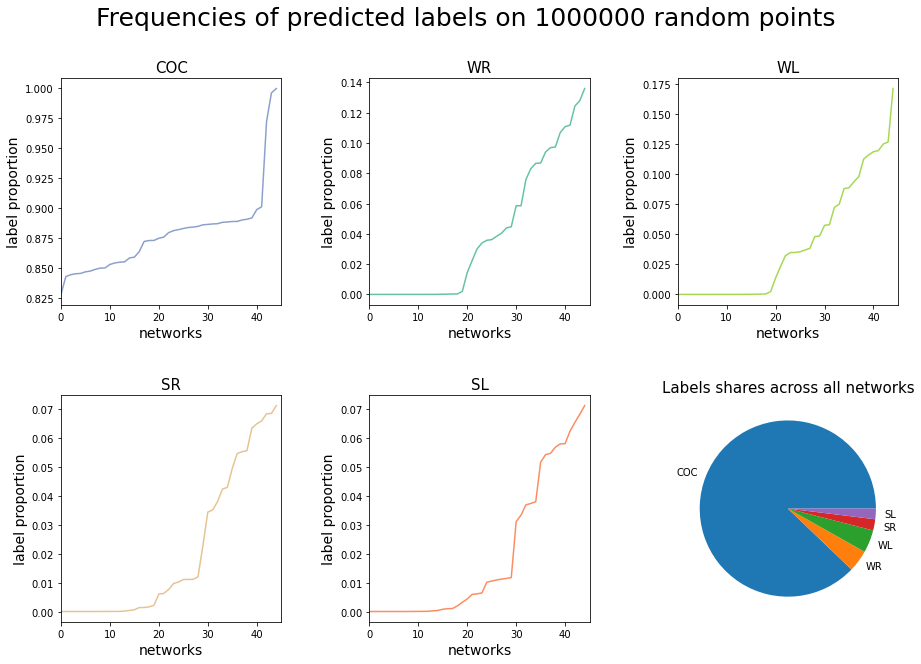

In [124]:
sorted_index = np.argsort(freq, axis=0)
npts = np.sum(freq[0,:])

fig, axes = plt.subplots(2, 3, figsize=(15, 10)) #, sharey=True)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
fig.suptitle("Frequencies of predicted labels on {0} random points".format(npts), size=25)

for k in range(5):
    axes[multiplot_pos[k]].plot(freq[:,k][sorted_index[:,k]]/npts, color = labels_color[k])
    axes[multiplot_pos[k]].set_xlim(0,45)
    axes[multiplot_pos[k]].set_title(ACAS_labels[k], size=15)
    axes[multiplot_pos[k]].set_xlabel("networks", size=14) ; axes[multiplot_pos[k]].set_ylabel("label proportion", size=14)

labels_shares = np.sum(freq, axis=0)
axes[multiplot_pos[5]].pie(labels_shares, labels=ACAS_labels) # autopct=lambda u:str(round(u,2))+'%'
axes[multiplot_pos[5]].set_title("Labels shares across all networks", size=15)
plt.show()

# 4. Identify similar networks using clustering methods

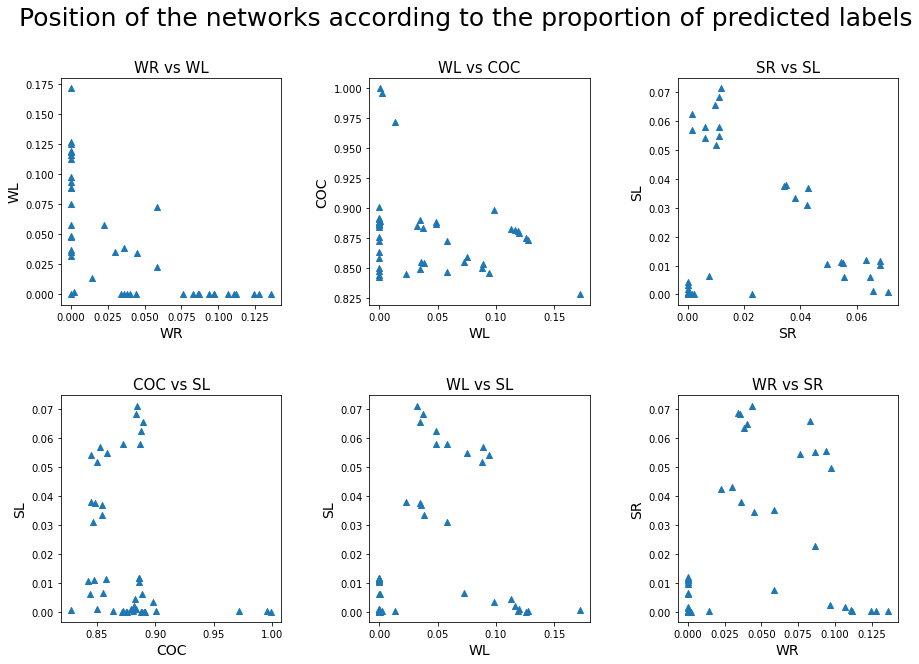

In [125]:
multiplot_pos = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
choose_inputs = [(1,2),(2,0),(3,4),(0,4),(2,4),(1,3)]
npts = np.sum(freq[0,:])

fig, axes = plt.subplots(2, 3, figsize=(15, 10)) #, sharey=True)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
fig.suptitle("Position of the networks according to the proportion of predicted labels", size=25)

for k in range(6):
    in0 = ACAS_labels[choose_inputs[k][0]] ; in1 = ACAS_labels[choose_inputs[k][1]]
    axes[multiplot_pos[k]].scatter(freq[:,choose_inputs[k][0]]/npts, freq[:,choose_inputs[k][1]]/npts, marker="^")
    axes[multiplot_pos[k]].set_xlabel(in0, size=14) ; axes[multiplot_pos[k]].set_ylabel(in1, size=14)
    axes[multiplot_pos[k]].set_title(in0 + " vs " + in1, size=15)
    
plt.show()

### Visualization with a PCA

We decide to use a PCA to get a better vizualisation of the different kinds of networks.

In [51]:
from sklearn.decomposition import PCA

In [75]:
pca = PCA(n_components=4)
pca_freq = pca.fit_transform(freq[:,[1,2,3,4]])
var_ratio = pca.explained_variance_ratio_
for k in range(4):
    print("CP{0} : {1}%".format(k+1,int(10000*var_ratio[k])/100))

print("> {0}% of the variance in the principal plane (CP1xCP2)".format(int(10000*(var_ratio[0]+var_ratio[1]))/100))

CP1 : 68.02%
CP2 : 18.09%
CP3 : 8.57%
CP4 : 5.3%
> 86.11% of the variance in the principal plane (CP1xCP2)


Text(0, 0.5, 'CP2 (18%)')

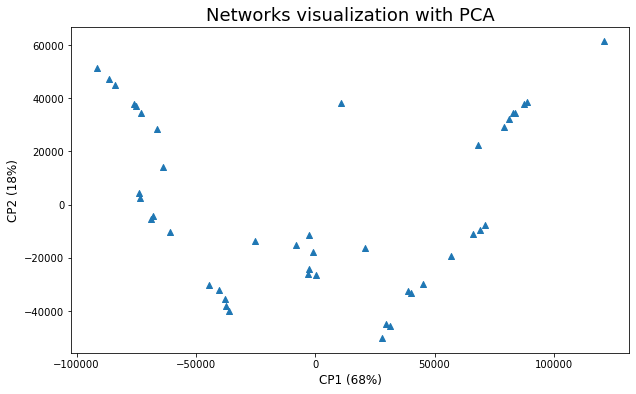

In [112]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_freq[:,0], pca_freq[:,1], marker="^")
plt.title("Networks visualization with PCA", size=18)
plt.xlabel("CP1 ({0}%)".format(int(100*var_ratio[0])), size=12)
plt.ylabel("CP2 ({0}%)".format(int(100*var_ratio[1])), size=12)

### Specific clustering technique

In [94]:
def get_network_type(net_pred, threshold = 0.001):
    """ Codage en base 2 du type du réseau : bit de poids k = 1 si net_pred[5-k]>borne et 0 sinon """
    borne = int(threshold*np.sum(net_pred))
    num = 0
    for k in range(0,5):
        num *= 2
        if net_pred[k]>borne:
            num += 1
    return(num)

In [95]:
nets_type = np.array([get_network_type(line) for line in freq]) #; print(nets_type)
nets_bool = np.ones(45)

for k in range(32): # 32 types de clusters
    id_nets = np.where(nets_type == k)[0]
    if len(id_nets) > 0:
        print("Cluster {0}".format(k))
        for i in id_nets:
            print("#{0} : {1}".format(i,freq[i])) ; nets_bool[i] = 0
        print("")

print("Remaining pts :")
for i in range(45):
    if nets_bool[i]:
        print("NET {0} : {1}".format(i,freq[i]))
print("")

Cluster 16
#8 : [999337    304    359      0      0]

Cluster 20
#23 : [827995      3 171610     34    358]
#24 : [872907      2 127074      0     17]
#25 : [881036      0 118912      0     52]
#26 : [874701      0 125298      0      1]
#43 : [879395      0 119835      0    770]

Cluster 21
#41 : [898563    101  98115     32   3189]
#42 : [882829      6 112821      0   4344]
#44 : [881906      0 116135      0   1959]

Cluster 23
#18 : [858984      4  75210  11072  54730]
#19 : [872825      3  58063  11088  58021]
#20 : [849879      4  88284  10154  51679]
#21 : [845450    188  93847   6216  54299]
#22 : [852915     42  88853   1350  56840]
#36 : [883656     16  37014  11039  68275]
#37 : [884600      0  32176  11948  71276]
#38 : [889918     13  34969   9652  65448]
#39 : [886843    270  48725   6068  58094]
#40 : [887983     19  48163   1384  62451]

Cluster 24
#14 : [863634 135917     22    346     81]
#15 : [872063 127905      5     27      0]
#16 : [875671 124312      0     17     

We go back to the PCA to see what the clusters look like in the principal plane

In [139]:
# We give each cluster a specific color

col10 = ['grey','green','yellow','orange','blue','red','purple','brown','pink']

unique_labels = np.unique(nets_type)
type2col = {}
for k in range(len(unique_labels)):
    type2col[unique_labels[k]] = col10[k]
clusters_colors = [ type2col[nets_type[k]] for k in range(len(nets_type)) ]

print("CLUSTER <-> COLOR")
for (clu,col) in list(type2col.items()):
    print("#{0} = {1}".format(clu,col))

CLUSTER <-> COLOR
#16 = grey
#20 = green
#21 = yellow
#23 = orange
#24 = blue
#26 = red
#27 = purple
#28 = brown
#31 = pink


Text(0, 0.5, 'CP2 (18%)')

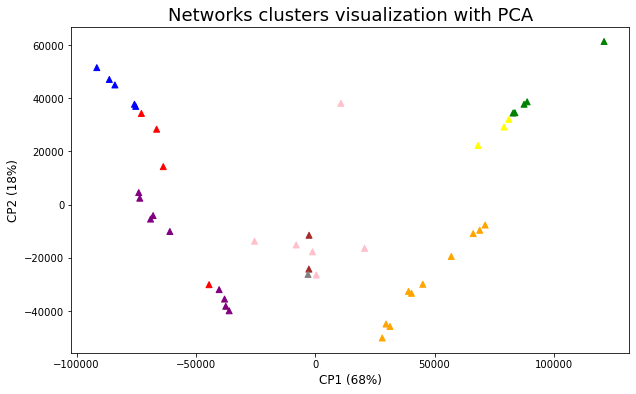

In [114]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_freq[:,0], pca_freq[:,1], color=clusters_colors, marker="^")
plt.title("Networks clusters visualization with PCA", size=18)
plt.xlabel("CP1 ({0}%)".format(int(100*var_ratio[0])), size=12)
plt.ylabel("CP2 ({0}%)".format(int(100*var_ratio[1])), size=12)

As we see on the PCA, we can choose to join clusters 20 and 21 (green and yellow) together as well as clusters 24 and 26 (blue and red). However, we decide to not do that for the moment because it will mix different kinds of networks in a same cluster.

In [145]:
# Identified clusters for {npts = 1000000 ; threshold = 0.001}
c20 = [23,24,25,26,43]
c21 = [41,42,44]
c24 = [14,15,16,17,34]
c26 = [31,32,33,35]
c27 = [9,10,11,12,13,27,28,29,30]
c23 = [18,19,20,21,22,36,37,38,39,40]
c28 = [6,7]
c31 = [0,1,2,3,4,5] # best balance net
c16 = [8] # COC net

nets_clusters = [c20,c21,c24,c26,c27,c23,c28,c31,c16]
clusters_mask = [bin(20)[2:], bin(21)[2:], bin(24)[2:], bin(26)[2:], bin(27)[2:],
                 bin(23)[2:], bin(28)[2:], bin(31)[2:], bin(16)[2:]]

print("### ================ NETWORKS CLUSTERING ============ ###\n")
for nc in range(len(nets_clusters)):
    print("----------------------- CLUSTER {0} -----------------------".format(nc+1))
    string_clusters = [str(k) for k in nets_clusters[nc]]
    print("Networks : {0}".format(" - ".join(string_clusters)))
    print("Mask = " + clusters_mask[nc])
    print("")

### ================ NETWORKS CLUSTERING ============ ###

----------------------- CLUSTER 1 -----------------------
Networks : 23 - 24 - 25 - 26 - 43
Mask = 10100

----------------------- CLUSTER 2 -----------------------
Networks : 41 - 42 - 44
Mask = 10101

----------------------- CLUSTER 3 -----------------------
Networks : 14 - 15 - 16 - 17 - 34
Mask = 11000

----------------------- CLUSTER 4 -----------------------
Networks : 31 - 32 - 33 - 35
Mask = 11010

----------------------- CLUSTER 5 -----------------------
Networks : 9 - 10 - 11 - 12 - 13 - 27 - 28 - 29 - 30
Mask = 11011

----------------------- CLUSTER 6 -----------------------
Networks : 18 - 19 - 20 - 21 - 22 - 36 - 37 - 38 - 39 - 40
Mask = 10111

----------------------- CLUSTER 7 -----------------------
Networks : 6 - 7
Mask = 11100

----------------------- CLUSTER 8 -----------------------
Networks : 0 - 1 - 2 - 3 - 4 - 5
Mask = 11111

----------------------- CLUSTER 9 -----------------------
Networks : 8
Mask = 1000